In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad

### RWMH with 1 mode

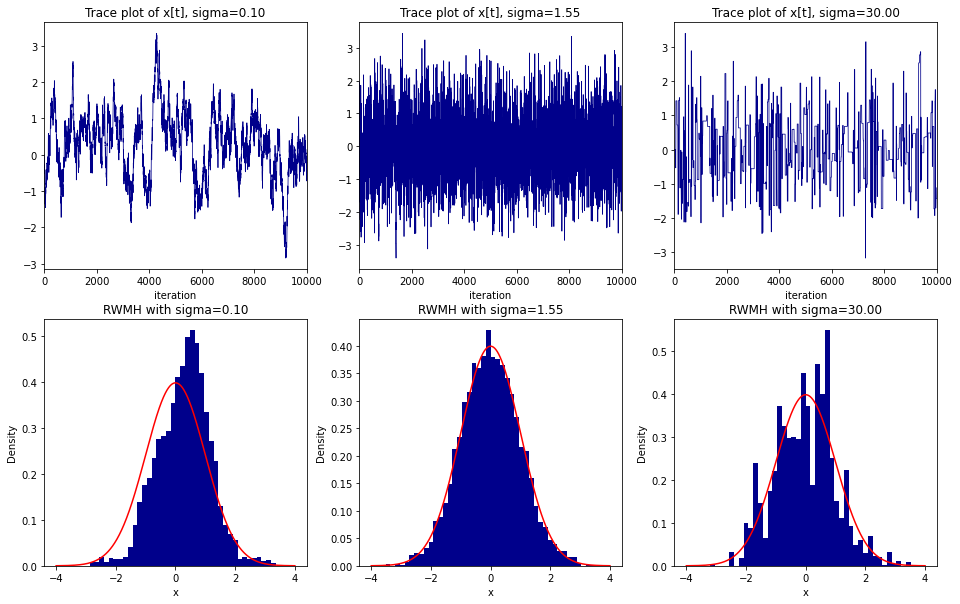

In [2]:
def RWMH(target_f, initial_state, proposal_g, num_samples):
    # Implemetns the Random Walk Metropolis Hastings (RWMH) algorithm
    samples = [initial_state]

    for n in range(num_samples-1):
        current = samples[-1]
        # Sample propose state with proposal_g
        propose = proposal_g(current)
        accept_prob = min(1, target_f(propose)/target_f(current))

        if np.random.uniform(0, 1) < accept_prob:   # Accept the new proposal
            samples.append(propose)
        else:   # Reject the new proposal
            samples.append(current)

    return np.array(samples)

N = 10000
def target_f(x): return norm.pdf(x, loc=0, scale=1)

initial_state = 0
# sqrt(2.4) is the optimal value for a normal distributed random walk proposal
sigma_list = [0.1, np.sqrt(2.4), 30]

plt.figure(figsize=(16, 10))
for i, sigma in enumerate(sigma_list):
    # Run RWMH algorithm
    def proposal_g(x): return np.random.normal(loc=x, scale=sigma)
    samples = RWMH(target_f, initial_state, proposal_g, N)

    # Plot trace plots
    plt.subplot(2, 3, i+1)
    plt.plot(samples, color='darkblue', linewidth=0.75)
    plt.title(f'Trace plot of x[t], sigma={sigma:.2f}')
    plt.xlim(0, 10000)
    plt.xticks(np.arange(0, 10001, 2000))
    plt.xlabel('iteration')

    # Plot density distributions
    plt.subplot(2, 3, i+4)
    plt.hist(samples, bins=50, range=(-4, 4), density=True, color='darkblue')
    plt.title(f'RWMH with sigma={sigma:.2f}')
    x_values = np.linspace(-4, 4, 10000)
    y_values = norm.pdf(x_values, loc=0, scale=1)
    plt.plot(x_values, y_values, color='red', label='True distribution')
    plt.xlabel('x')
    plt.ylabel('Density')

plt.show()


#### RWMH with 2 modes

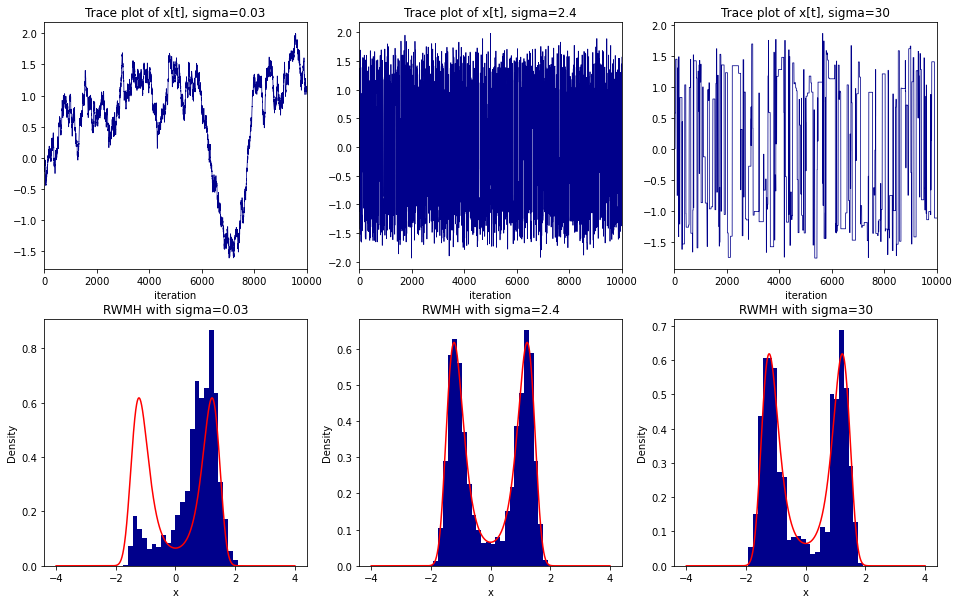

In [3]:
def RWMH(target_f, initial_state, proposal_g, num_samples):
    # Implemetns the Random Walk Metropolis Hastings (RWMH) algorithm
    samples = [initial_state]

    for n in range(num_samples-1):
        current = samples[-1]
        # Sample propose state with proposal_g
        propose = proposal_g(current)
        accept_prob = min(1, target_f(propose)/target_f(current))

        if np.random.uniform(0, 1) < accept_prob:   # Accept the new proposal
            samples.append(propose)
        else:   # Reject the new proposal
            samples.append(current)

    return np.array(samples)


N = 10000
def V(x): return x**4 - 3*x**2 + 2
def target_f(x): return np.exp(-V(x))

initial_state = 0
sigma_list = [0.03, 2.4, 30]
# Calculate normalization constant for target_f
normalization_constant, _ = quad(target_f, -np.inf, np.inf)

plt.figure(figsize=(16, 10))
for i, sigma in enumerate(sigma_list):
    # Run RWMH algorithm
    def proposal_g(x): return np.random.normal(loc=x, scale=sigma)
    samples = RWMH(target_f, initial_state, proposal_g, N)

    # Plot trace plots
    plt.subplot(2, 3, i+1)
    plt.plot(samples, color='darkblue', linewidth=0.75)
    plt.title(f'Trace plot of x[t], sigma={sigma}')
    plt.xlim(0, 10000)
    plt.xticks(np.arange(0, 10001, 2000))
    plt.xlabel('iteration')

    # Plot density distributions
    plt.subplot(2, 3, i+4)
    plt.hist(samples, bins=50, range=(-4, 4), density=True, color='darkblue')
    plt.title(f'RWMH with sigma={sigma}')
    x_values = np.linspace(-4, 4, 10000)
    y_values = target_f(x_values) / normalization_constant
    plt.plot(x_values, y_values, color='red', label='True distribution')
    plt.xlabel('x')
    plt.ylabel('Density')

plt.show()


### MALA with 1 mode

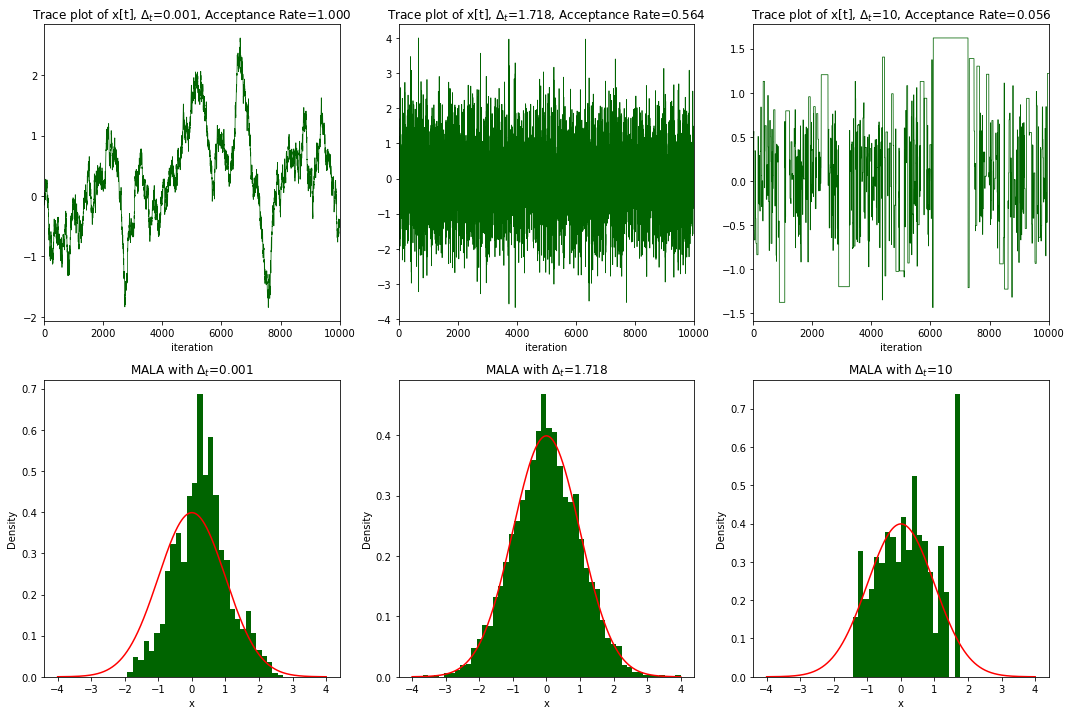

In [4]:
def MALA(target_f, grad_target_logf, initial_state, delta_t, num_samples):
    # Implements the Metropolis Adjusted Langevin Algorithm (MALA)
    samples = [initial_state]
    accept_count = 0

    for n in range(num_samples-1):
        current = samples[-1]
        # Sample propose based on Euler-Muruyama discretization
        propose = current + delta_t * \
            grad_target_logf(current) + np.sqrt(2 * delta_t) * \
            np.random.normal(0, 1)

        # Correct via the Metropolis Hastings Algorithm
        q_current_propose = norm.pdf(
            propose, loc=current + delta_t * grad_target_logf(current), scale=np.sqrt(2 * delta_t))
        q_propose_current = norm.pdf(
            current, loc=propose + delta_t * grad_target_logf(propose), scale=np.sqrt(2 * delta_t))
        accept_prob = min(1, (target_f(propose) * q_propose_current) /
                          (target_f(current) * q_current_propose))
        if np.random.uniform(0, 1) < accept_prob:   # Accept the new proposal
            samples.append(propose)
            accept_count += 1
        else:   # Reject the new proposal
            samples.append(current)

    acceptance_rate = accept_count / num_samples
    return np.array(samples), acceptance_rate

delta_t_list = [0.001, 1.718, 10]
initial_state = 0
def target_f(x): return norm.pdf(x, loc=0, scale=1)

N = 10000
# derivative of the potential function (log(f))
def grad_target_logf(x): return -x

plt.figure(figsize=(18, 12))
for i, delta_t in enumerate(delta_t_list):
    # Run MALA algorithm
    samples, acceptance_rate = MALA(
        target_f, grad_target_logf, initial_state, delta_t, N)

    # Plot trace plots
    plt.subplot(2, 3, i+1)
    plt.plot(samples, color='darkgreen', linewidth=0.75)
    plt.title(
        f'Trace plot of x[t], $\Delta_t$={delta_t}, Acceptance Rate={acceptance_rate:.3f}')
    plt.xlim(0, 10000)
    plt.xticks(np.arange(0, 10001, 2000))
    plt.xlabel('iteration')

    # Plot density distributions
    plt.subplot(2, 3, i+4)
    plt.hist(samples, bins=50, range=(-4, 4), density=True, color='darkgreen')
    plt.title(f'MALA with $\Delta_t$={delta_t}')
    x_values = np.linspace(-4, 4, 10000)
    y_values = norm.pdf(x_values, loc=0, scale=1)
    plt.plot(x_values, y_values, color='red', label='True distribution')
    plt.xlabel('x')
    plt.ylabel('Density')

plt.show()


#### Explore delta t and acceptance rate

Optimal delta_t: 1.718


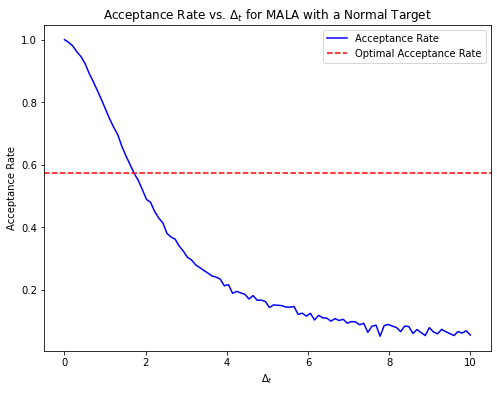

In [5]:
def target_f(x): return norm.pdf(x, loc=0, scale=1)
def grad_target_logf(x): return -x
initial_state = 0
optimal_acceptance_rate = 0.574
delta_t_values = np.linspace(0.001, 10, 100)
N = 10000
acceptance_rates = []

num_runs = 1
for delta_t in delta_t_values:
    acceptance_rate_total = 0
    for i in range(num_runs):
        _, acceptance_rate = MALA(target_f, grad_target_logf, initial_state, delta_t, N)
        acceptance_rate_total += acceptance_rate
    acceptance_rates.append(acceptance_rate_total / num_runs)

# Identify the optimal delta_t
acceptance_rate_diffs = np.abs(
    np.array(acceptance_rates) - optimal_acceptance_rate)
optimal_delta_t = delta_t_values[np.argmin(acceptance_rate_diffs)]
print(f"Optimal delta_t: {optimal_delta_t}")

plt.figure(figsize=(8, 6))
plt.plot(delta_t_values, acceptance_rates,
         color='blue', label='Acceptance Rate')
plt.axhline(y=optimal_acceptance_rate, color='red',
            linestyle='--', label='Optimal Acceptance Rate')
plt.title('Acceptance Rate vs. $\Delta_t$ for MALA with a Normal Target')
plt.xlabel('$\Delta_t$')
plt.ylabel('Acceptance Rate')
plt.legend()
plt.show()


#### MALA with 2 modes

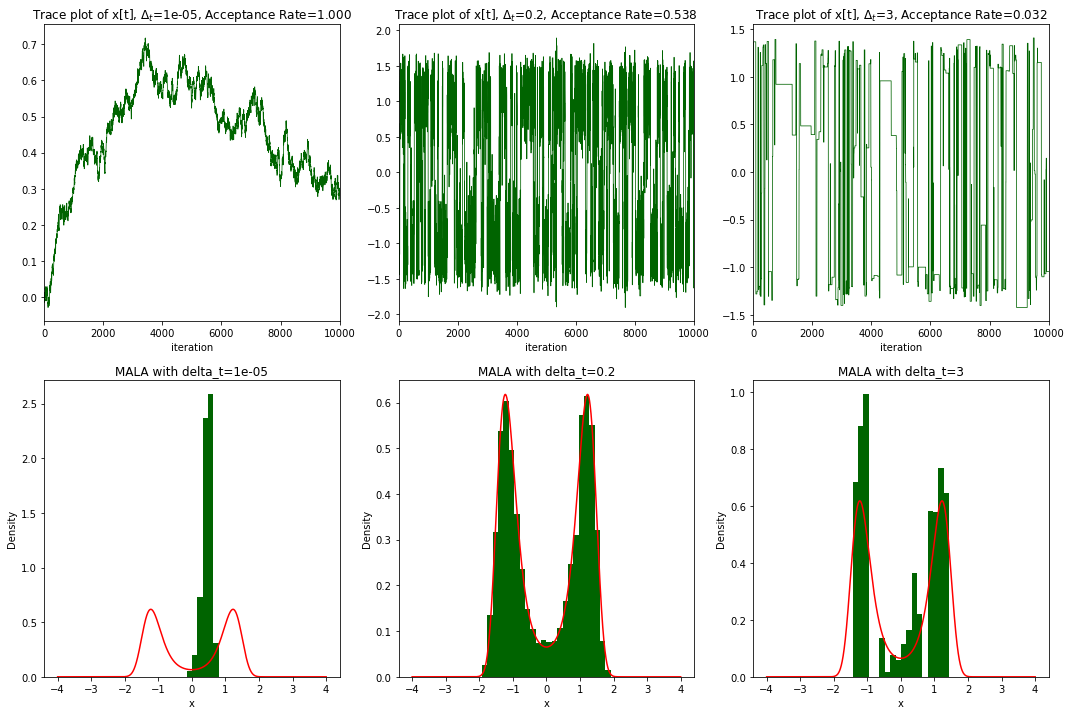

In [6]:
def MALA(target_f, grad_target_logf, initial_state, delta_t, num_samples):
    # Implements the Metropolis Adjusted Langevin Algorithm (MALA)
    samples = [initial_state]
    accept_count = 0

    for n in range(num_samples-1):
        current = samples[-1]
        # Sample propose based on Euler-Muruyama discretization
        propose = current + delta_t * \
            grad_target_logf(current) + np.sqrt(2 * delta_t) * \
            np.random.normal(0, 1)

        # Correct via the Metropolis Hastings Algorithm
        q_current_propose = norm.pdf(
            propose, loc=current + delta_t * grad_target_logf(current), scale=np.sqrt(2 * delta_t))
        q_propose_current = norm.pdf(
            current, loc=propose + delta_t * grad_target_logf(propose), scale=np.sqrt(2 * delta_t))
        accept_prob = min(1, (target_f(propose) * q_propose_current) /
                          (target_f(current) * q_current_propose))
        if np.random.uniform(0, 1) < accept_prob:   # Accept the new proposal
            samples.append(propose)
            accept_count += 1
        else:   # Reject the new proposal
            samples.append(current)

    acceptance_rate = accept_count / num_samples
    return np.array(samples), acceptance_rate

delta_t_list = [1e-5, 0.2, 3]
initial_state = 0
N = 10000
def V(x): return x**4 - 3*x**2 + 2
def target_f(x): return np.exp(-V(x))
# derivative of the potential function (log(f))
def grad_target_logf(x): return -(4*x**3 - 6*x)

# Calculate normalization constant for target_f
normalization_constant, _ = quad(target_f, -np.inf, np.inf)

plt.figure(figsize=(18, 12))
for i, delta_t in enumerate(delta_t_list):
    # Run MALA algorithm
    samples, acceptance_rate = MALA(
        target_f, grad_target_logf, initial_state, delta_t, N)

    # Plot trace plots
    plt.subplot(2, 3, i+1)
    plt.plot(samples, color='darkgreen', linewidth=0.75)
    plt.title(f'Trace plot of x[t], $\Delta_t$={delta_t}, Acceptance Rate={acceptance_rate:.3f}')
    plt.xlim(0, 10000)
    plt.xticks(np.arange(0, 10001, 2000))
    plt.xlabel('iteration')

    # Plot density distributions
    plt.subplot(2, 3, i+4)
    plt.hist(samples, bins=50, range=(-4, 4), density=True, color='darkgreen')
    plt.title(f'MALA with delta_t={delta_t}')
    x_values = np.linspace(-4, 4, 10000)
    y_values = target_f(x_values) / normalization_constant
    plt.plot(x_values, y_values, color='red', label='True distribution')
    plt.xlabel('x')
    plt.ylabel('Density')

plt.show()


In [7]:
from scipy.stats import multivariate_normal as mvn

D = 10  # dimension
N = 10000  # number of samples

# target distribution is a 10-dimensional Gaussian
mean = np.zeros(D)
cov = np.eye(D)  # identity matrix
target_f = mvn(mean, cov)
# gradient of log of target_f
def grad_target_logf(x): return -x  # for Gaussian

# initialize MALA and RWMH
initial_state = np.zeros(D)
# optimal delta_t for MALA
delta_t = 0.9
# optimal sigma for RWMH
sigma = (np.sqrt(2.4))**(1/10)

# Run RWMH and MALA
def MALA_D(target_f, grad_target_logf, initial_state, delta_t, num_samples):
    samples = [initial_state]
    dim = len(initial_state)
    I = np.eye(dim)
    # counter for number of accepted proposals
    num_accepted = 0
    for n in range(num_samples-1):
        current = samples[-1]
        # Sample propose based on Euler-Muruyama discretization
        propose = current + delta_t * \
            grad_target_logf(current) + np.sqrt(2 * delta_t) * \
            np.random.normal(0, 1, size=dim)
        # Correct via the Metropolis Hastings Algorithm
        q_current_propose = mvn.pdf(
            propose, mean=current + delta_t * grad_target_logf(current), cov=np.sqrt(2 * delta_t)*I)
        q_propose_current = mvn.pdf(
            current, mean=propose + delta_t * grad_target_logf(propose), cov=np.sqrt(2 * delta_t)*I)
        accept_prob = min(1, (target_f.pdf(
            propose) * q_propose_current) / (target_f.pdf(current) * q_current_propose))
        if np.random.uniform(0, 1) < accept_prob:   # Accept the new proposal
            samples.append(propose)
            num_accepted += 1  # increment the accepted counter
        else:   # Reject the new proposal
            samples.append(current)

    acceptance_rate = num_accepted / num_samples  # calculate acceptance rate
    print(f"Acceptance Rate: {acceptance_rate:.3f}")
    return np.array(samples)

def proposal_g(x): return np.random.normal(loc=x, scale=sigma, size=D)


samples_RWMH = RWMH(target_f.pdf, initial_state, proposal_g, N)
samples_MALA = MALA_D(target_f, grad_target_logf, initial_state, delta_t, N)

# Comparing the sample means from MALA and RWMH
mean_RWMH = np.mean(samples_RWMH, axis=0)
cov_RWMH = np.cov(samples_RWMH.T)
mean_MALA = np.mean(samples_MALA, axis=0)
cov_MALA = np.cov(samples_MALA.T)

print("RWMH mean:")
print(mean_RWMH)
print("MALA mean:")
print(mean_MALA)

Acceptance Rate: 0.547
RWMH mean:
[ 0.04679262  0.05208935 -0.01271356  0.01862287  0.01407759  0.08936924
  0.04091525  0.07390979  0.15531712 -0.01698285]
MALA mean:
[ 0.01874334 -0.00177408 -0.02517551 -0.02117803  0.00108321  0.02942895
 -0.01092106  0.02750054 -0.01000333 -0.00082429]


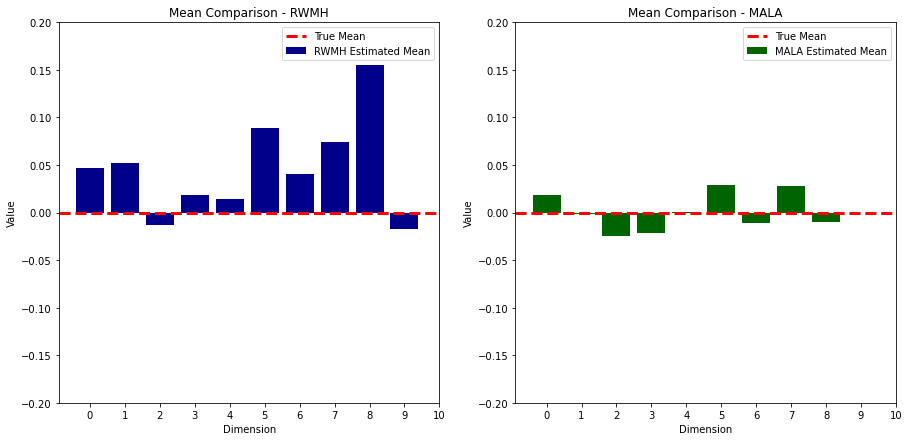

In [8]:
# Calculate estimated mean and covariance for RWMH and MALA
mean_RWMH = np.mean(samples_RWMH, axis=0)
mean_MALA = np.mean(samples_MALA, axis=0)

# Plot estimated means
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.bar(range(D), mean_RWMH, label='RWMH Estimated Mean', color='darkblue')
plt.axhline(0, color='red', label='True Mean', linewidth=3, linestyle='--')
plt.xticks(range(D+1))
plt.ylim(-0.2, 0.2)
plt.legend()
plt.title("Mean Comparison - RWMH")
plt.xlabel("Dimension")
plt.ylabel("Value")

plt.subplot(1, 2, 2)
plt.bar(range(D), mean_MALA, label='MALA Estimated Mean', color='darkgreen')
plt.axhline(0, color='red', label='True Mean', linewidth=3, linestyle='--')
plt.xticks(range(D+1))
plt.ylim(-0.2, 0.2)
plt.legend()
plt.title("Mean Comparison - MALA")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.show()